# Model development

This notebook is intended for the development of price forecasting models and is organised as follows
- Section 1: Data is prepared and features (exogenous variables) are chosen/created
- Section 2: Electricity prices are modelled as an autoregressive time series with linear and non-linear dependence on the autoregressive terms and exogenous variables ("linear ARX model")

## 1. Setup

Load data:

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn-v0_8-colorblind')

# read CSVs
base_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "processed")
df_electricity = pd.read_csv(os.path.join(base_dir, "electricity_data.csv"), parse_dates=['settlementDate'])
df_forecast = pd.read_csv(os.path.join(base_dir, "forecast_data.csv"), parse_dates=['SETTLEMENT_DATE'])

# clean and merge dataframes
df_electricity.drop(columns={'startTime'}, inplace=True)
df_electricity.rename(columns={'settlementDate': 'SETTLEMENT_DATE', 'settlementPeriod': 'SETTLEMENT_PERIOD'}, inplace=True)
df = pd.merge(df_electricity, df_forecast, on=['SETTLEMENT_DATE', 'SETTLEMENT_PERIOD'], how='inner')

# create time stamps with local time zone
df['timestamp_utc'] = (df['SETTLEMENT_DATE'] + pd.to_timedelta((df['SETTLEMENT_PERIOD'] - 1) * 30, unit='m')).dt.tz_localize('UTC')
df['DATETIME'] = df['timestamp_utc'].dt.tz_convert('Europe/London')
df.drop(columns=['timestamp_utc'], inplace=True)

# sort by settlement date and period
df = df.sort_values(by='DATETIME', ascending=True).reset_index(drop=True)
df.set_index('DATETIME', inplace=True)

df.head()

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,BIOMASS,GAS,COAL,OIL,NUCLEAR,SOLAR,WIND,OTHER,...,marketIndexPrice,marketIndexTradingVolume,naturalGasPrice,DEMAND_FORECAST,EMBEDDED_WIND_FORECAST,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_FORECAST,EMBEDDED_SOLAR_CAPACITY,WIND_CAPACITY,WIND_FORECAST
DATETIME,,,,,,,,,,,,,,,,,,,,,
2021-01-02 00:00:00+00:00,2021-01-02,1,2466.0,11176.0,0.0,0.0,5923.0,0.0,3817.661,570.0,...,57.47,677.00,19.578,26422.0,879,6527,0,13082,15729,2383
2021-01-02 00:30:00+00:00,2021-01-02,2,2467.0,11235.0,0.0,0.0,5929.0,0.0,3989.388,549.0,...,60.45,655.90,19.578,26622.0,867,6527,0,13082,15729,2382
2021-01-02 01:00:00+00:00,2021-01-02,3,2456.0,11461.0,0.0,0.0,5919.0,0.0,3912.158,652.0,...,58.17,437.10,19.578,26229.0,867,6527,0,13082,15729,2398
2021-01-02 01:30:00+00:00,2021-01-02,4,2463.0,10885.0,0.0,0.0,5932.0,0.0,3891.883,524.0,...,60.20,516.80,19.578,25836.0,863,6527,0,13082,15729,2429
2021-01-02 02:00:00+00:00,2021-01-02,5,2481.0,10643.0,0.0,0.0,5928.0,0.0,3907.977,525.0,...,57.56,469.95,19.578,25443.0,863,6527,0,13082,15729,2474


### 1.2 Feature Engineering

**Day-ahead forecasting setup**: At 09:00 on Day T, we forecast electricity prices for all settlement periods on Day T+1.

In our exploratory data analysis (see `exploratory_analysis.ipynb`), we inspected a number of variables and their relationship with electricity prices using actual historical data. Most of the variables we looked at appeared to be correlated with electricity prices, but some are redundant since we don't need to include both wind speed and wind generation for example. Additionally, we saw that electricity prices at time $t$ were autocorrelated with prices at earlier times, which suggests that we should use time-lagged electricity prices as autoregressive features in our models.

There are some restrictions on the available data for forecasted exogenous variables. It is possible to collect forecasts of electricity demand, wind and solar generation from the National Energy System Operator (NESO) website, as well as weather forecasts from the UK Met Office, but prices of futures contracts on goal and gas are often behind paywalls. Currently available (day-ahead) forecasted exogenous variables are:
- Electricity demand 
- Metered and embedded wind generation 
- Embedded solar generation
- Temporal information (weekends, holidays, etc.)

We will have to make our own forecasts or collect more data from public APIs if we want to include other exogenous variables.

**Autoregressive terms:** (see autocorrelation plots in `notebooks/exploratory_analysis.ipynb` for justification): 
- Lagged price from previous $p$ settlement periods
- Lagged price from previous day for the same settlement period
- Lagged price from same day on the previous week for the same settlement period

**Exogenous variables:**
- Suppressed demand: Use `demand_forecast - embedded_generation_forecast` since embedded generation effectively suppresses demand
- Metered wind generation
- Gas prices: We have daily mean gas prices - use Day T-1 prices for values on Day T+1 (can't use Day T since it contains information from after the time of forecasting)

**Temporal features**:
- Holidays
- Weekends

*Optional extensions:*
- Non-renewable generation forecasts using 7-day rolling averages
- Interaction terms, for example `gas_price * gas_generation`

In [2]:
from electricity_pricing.features import is_holiday, is_weekend, add_intercept
from electricity_pricing.utils import timeshift

feature_config = {
    # Autoregressive features
    'price_lag_sp': [1, 2, 3], # settlement period lags (consecutive half-hours)
    'price_lag_day': [1, 7], # day lags (same period on previous days)
    
    # Exogenous variables
    'suppressed_demand': True, # (demand - embedded generation) forecast
    'wind_gen': True, # wind generation forecast
    'gas_price': True,  # daily mean gas price (lagged 2 days)
    
    # Temporal features
    'is_holiday': True,
    'is_weekend': True,
    
    # Linear regression intercept
    'intercept': True,
}

feature_cols = []

# price lagged by settlement periods
if feature_config.get('price_lag_sp'):
    for lag in feature_config['price_lag_sp']:
        df[f'price_lag_sp_{lag}'] = df['marketIndexPrice'].shift(lag)
        feature_cols.append(f'price_lag_sp_{lag}')

# price lagged by days
if feature_config.get('price_lag_day'):
    for dlag in feature_config['price_lag_day']:
        df[f'price_lag_day_{dlag}'] = timeshift(df['marketIndexPrice'], pd.Timedelta(days=-dlag))
        feature_cols.append(f'price_lag_day_{dlag}')

if feature_config.get('suppressed_demand'):
    df['suppressed_demand'] = (df['DEMAND_FORECAST'] - df['EMBEDDED_WIND_FORECAST'] - df['EMBEDDED_SOLAR_FORECAST'])
    feature_cols.append('suppressed_demand')

if feature_config.get('wind_gen'):
    df['wind_gen'] = df['WIND_FORECAST']
    feature_cols.append('wind_gen')

if feature_config.get('gas_price'):
    df['gas_price'] = timeshift(df['naturalGasPrice'], pd.Timedelta(days=-2))
    feature_cols.append('gas_price')

if feature_config.get('is_holiday'):
    df['is_holiday'] = is_holiday(df, 'SETTLEMENT_DATE', country='GB')
    feature_cols.append('is_holiday')

if feature_config.get('is_weekend'):
    df['is_weekend'] = is_weekend(df, 'SETTLEMENT_DATE')
    feature_cols.append('is_weekend')

if feature_config.get('intercept'):
    add_intercept(df, column_name='intercept', inplace=True)
    feature_cols.append('intercept')

# drop NaNs created by lags
df = df.dropna(how='any')

features = df[feature_cols].copy()
target = df['marketIndexPrice'].copy()

print(f"Features shape: {features.shape}")
print(f"Number of features: {len(feature_cols)}")
print(f"\nFeature names: {feature_cols}")

Features shape: (59752, 11)
Number of features: 11

Feature names: ['price_lag_sp_1', 'price_lag_sp_2', 'price_lag_sp_3', 'price_lag_day_1', 'price_lag_day_7', 'suppressed_demand', 'wind_gen', 'gas_price', 'is_holiday', 'is_weekend', 'intercept']


Spit the data into a training and testing set, and create feature matrix $\mathbf{X}$ and target vector $y$.

In [3]:
# Train-test split
from electricity_pricing.utils import train_test_split

train_range_str = ["2021-02-01", "2024-02-01"]
test_range_str = ["2024-02-02", "2024-12-01"]
train_range = [pd.to_datetime(ts).tz_localize("Europe/London") for ts in train_range_str]
test_range = [pd.to_datetime(ts).tz_localize("Europe/London") for ts in test_range_str]

X_train, X_test = train_test_split(features, train_range, test_range)
y_train, y_test = train_test_split(target, train_range, test_range)
assert (X_train.index == y_train.index).all()
assert (X_test.index == y_test.index).all()

print(f"Training set shape: X = {X_train.shape}, y = {y_train.shape}")
print(f"Test set shape: X = {X_test.shape}, y = {y_test.shape}")
print(f"\nFeatures used ({len(features)} total):")
for i, feature_name in enumerate(features.keys()):
    print(f"  {i}: {feature_name}")

Training set shape: X = (43429, 11), y = (43429,)
Test set shape: X = (13945, 11), y = (13945,)

Features used (59752 total):
  0: price_lag_sp_1
  1: price_lag_sp_2
  2: price_lag_sp_3
  3: price_lag_day_1
  4: price_lag_day_7
  5: suppressed_demand
  6: wind_gen
  7: gas_price
  8: is_holiday
  9: is_weekend
  10: intercept


## 2. ARX Models

### 2.1 Linear ARX

Let's propose an electricity pricing model of the form

$$
P_{t} = \sum^{\ell}_{k=1} \alpha_k P_{t - k} + \boldsymbol{\beta}^T \mathbf{X}^f_{t} + \epsilon_t,
$$

where
- $P_t$: price of electricity at time t
- $\mathbf{X}^f_t$: a vector of forecasted exogenous variables
- $\boldsymbol{\alpha}, \boldsymbol{\beta}$: some parameters
- $\epsilon_t$: noise term

The proposed model is an autoregressive model with exogenous variables (ARX) with a linear dependence on the parameters $\boldsymbol{\theta} = [\boldsymbol{\alpha}, \boldsymbol{\beta}]$. To find the parameters, we minimise the cost function
$$C = \sum_t (P_t  - \boldsymbol{\theta}^T \mathbf{X}_t)^2,$$
where $\mathbf{X}_t$ contains all the exogenous variables and autoregressive terms. The cost function is minimised by
$$\boldsymbol{\theta} = \left( \mathbf{X}^T_t \mathbf{X}_t \right)^{-1} \mathbf{X}_t y_t$$
for all $t$. Once we have the parameters $\boldsymbol{\theta}$, we can use them to make predictions on the next price in the series.

Create an ARX model that uses linear regression to fit its parameters:

In [26]:
from electricity_pricing.models import ARXModel
from electricity_pricing.regressors import LinearRegression

model = ARXModel(regressor=LinearRegression())

Train the model:

In [27]:
model.fit(X_train.values, y_train.values)

# display parameters
print(f"Parameters:")
feature_names = list(features.keys())
for feature, coef in zip(feature_names, model.get_params()):
    print(f"  {feature:20s}= {coef:.2e}")

Parameters:
  price_lag_sp_1      = 9.93e-01
  price_lag_sp_2      = -3.54e-02
  price_lag_sp_3      = -7.15e-02
  price_lag_day_1     = 4.80e-02
  price_lag_day_7     = 2.18e-02
  suppressed_demand   = 8.51e-05
  wind_gen            = -3.64e-04
  gas_price           = 9.79e-02
  is_holiday          = -2.22e+00
  is_weekend          = -1.16e+00
  intercept           = 1.86e+00


Generate predictions on both training and test sets and evaluate model performance:

In [28]:
# Perform inference
y_train_pred = model.predict(X_train.values)
y_test_pred = model.predict(X_test.values)

In [29]:
from electricity_pricing import evaluation_metrics as metrics

def evaluate_model(y_true, y_pred, dataset_name):
    rmse = metrics.rmse(y_true, y_pred)
    rel_rmse = metrics.relative_rmse(y_true, y_pred)
    mae = metrics.mae(y_true, y_pred)
    mape = metrics.mape(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print(f"\n{dataset_name} Set Metrics:")
    print(f"  RMSE: {rmse:.4f} £/MWh")
    print(f"  Relative RMSE: {rel_rmse:.4f}")
    print(f"  MAE:  {mae:.4f} £/MWh")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  R²:   {r2:.4f}")
    
    return {'rmse': rmse, 'rel_rse': rel_rmse, 'mae': mae, 'mape': mape, 'r2': r2}

In [30]:
# Evaluate model
train_metrics = evaluate_model(y_train, y_train_pred, "Training")
test_metrics = evaluate_model(y_test, y_test_pred, "Test")


Training Set Metrics:
  RMSE: 20.1925 £/MWh
  Relative RMSE: 3.1417
  MAE:  10.3358 £/MWh
  MAPE: 18.62%
  R²:   0.9514

Test Set Metrics:
  RMSE: 8.1312 £/MWh
  Relative RMSE: 3.7217
  MAE:  5.1291 £/MWh
  MAPE: 28.83%
  R²:   0.9247


Plot predictions:

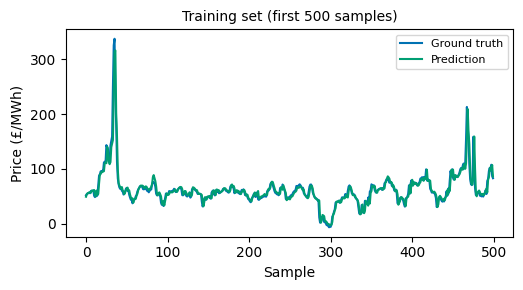

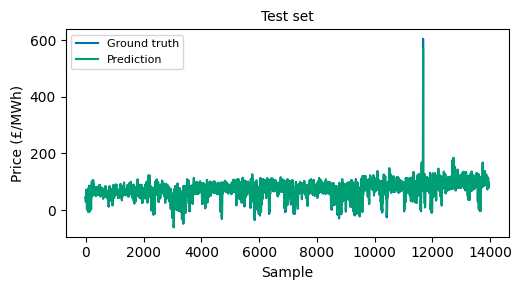

In [31]:
# Training set
fig, ax = plt.subplots(figsize=(16/3, 9/3), layout='tight')
ax.plot(y_train[:500], label='Ground truth')
ax.plot(y_train_pred[:500], label='Prediction')
ax.set_xlabel('Sample', fontsize=10)
ax.set_ylabel('Price (£/MWh)', fontsize=10)
ax.set_title('Training set (first 500 samples)', fontsize=10)
ax.legend(fontsize=8)
plt.show()
# Test set
fig, ax = plt.subplots(figsize=(16/3, 9/3), layout='tight')
ax.plot(y_test, label='Ground truth')
ax.plot(y_test_pred, label='Prediction')
ax.set_xlabel('Sample', fontsize=10)
ax.set_ylabel('Price (£/MWh)', fontsize=10)
ax.set_title(f'Test set', fontsize=10)
ax.legend(fontsize=8)
plt.show()

Plot residuals:

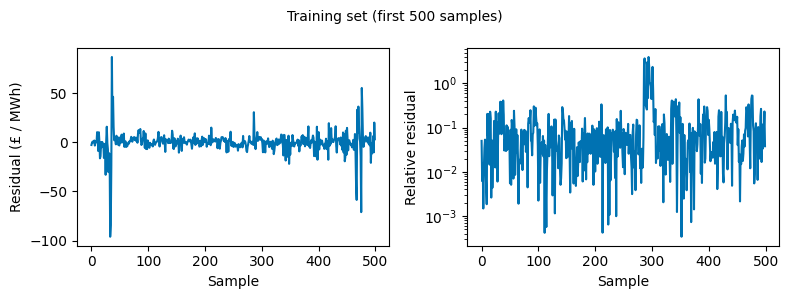

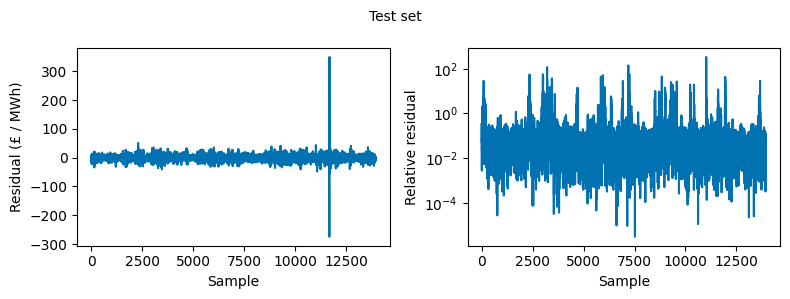

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

residuals_train = y_train_pred - y_train
residuals_test = y_test_pred - y_test
rel_residuals_train = np.abs(residuals_train) / np.abs(y_train)
rel_residuals_test = np.abs(residuals_test) / np.abs(y_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16/2, 9/3), layout='tight')
plt.suptitle('Training set (first 500 samples)', fontsize=10)
# residuals
ax1.plot(residuals_train[:500])
ax1.set_xlabel('Sample', fontsize=10)
ax1.set_ylabel('Residual (£ / MWh)', fontsize=10)
# relative residuals
ax2.plot(rel_residuals_train[:500])
ax2.set_xlabel('Sample', fontsize=10)
ax2.set_ylabel('Relative residual', fontsize=10)
ax2.set_yscale('log')
plt.show()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16/2, 9/3), layout='tight')
plt.suptitle('Test set', fontsize=10)
# residuals
ax1.plot(residuals_test)
ax1.set_xlabel('Sample', fontsize=10)
ax1.set_ylabel('Residual (£ / MWh)', fontsize=10)
# relative residuals
ax2.plot(rel_residuals_test)
ax2.set_xlabel('Sample', fontsize=10)
ax2.set_ylabel('Relative residual', fontsize=10)
ax2.set_yscale('log')
plt.show()

Analyse residuals:

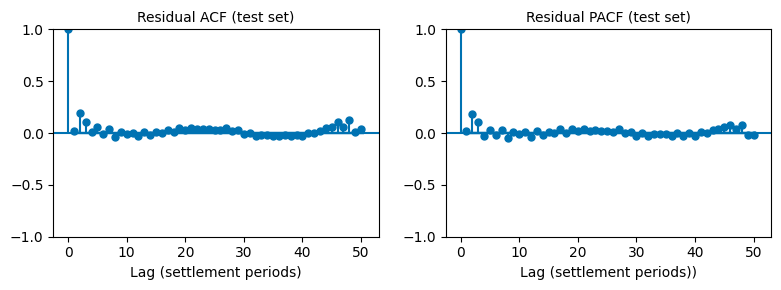

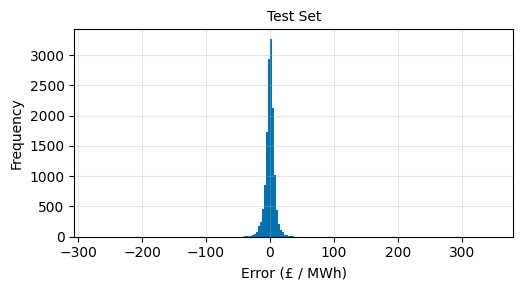

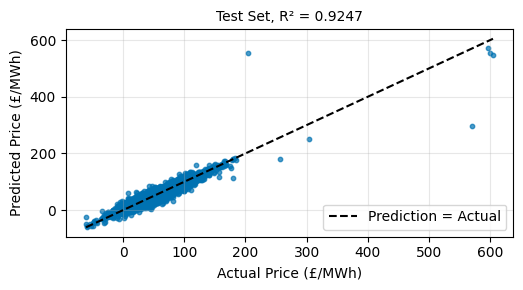

In [46]:
# residual auto-correlation and partial auto-correlations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16/2, 9/3), layout='tight')
plot_acf(residuals_test, lags=50, ax=ax1)
ax1.set_title('Residual ACF (test set)', fontsize=10)
ax1.set_xlabel('Lag (settlement periods)', fontsize=10)
plot_pacf(residuals_test, lags=50, ax=ax2)
ax2.set_title('Residual PACF (test set)', fontsize=10)
ax2.set_xlabel('Lag (settlement periods))', fontsize=10)
plt.show()
# histogram of errors
fig, ax = plt.subplots(figsize=(16/3, 9/3), layout='tight')
ax.hist(residuals_test, bins=200)
ax.set_xlabel('Error (£ / MWh)', fontsize=10)
ax.set_ylabel('Frequency', fontsize=10)
ax.set_title(f'Test Set', fontsize=10)
ax.grid(True, alpha=0.3)
plt.show()
# predicted vs actual prices
fig, ax = plt.subplots(figsize=(16/3, 9/3), layout='tight')
ax.scatter(y_test, y_test_pred, alpha=0.7, s=10)
ax.set_xlabel('Actual Price (£/MWh)', fontsize=10)
ax.set_ylabel('Predicted Price (£/MWh)', fontsize=10)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], ls='--', color='black', label='Prediction = Actual')
ax.legend()
ax.set_title(f'Test Set, R² = {test_metrics["r2"]:.4f}', fontsize=10)
ax.grid(True, alpha=0.3)
plt.show()

## 2.2 Regularised linear ARX

Let's explore regressors that use regularisation to reduce overfitting:

In [47]:
from sklearn.linear_model import Ridge, Lasso

model_ridge = ARXModel(regressor=Ridge(alpha=1.0))
model_ridge.fit(X_train.values, y_train.values)

model_lasso = ARXModel(regressor=Lasso(alpha=0.1, max_iter=10000))
model_lasso.fit(X_train.values, y_train.values)

print("Fitted models with Ridge and Lasso regression.")

Fitted models with Ridge and Lasso regression.


In [48]:
# Evaluate Ridge model
y_train_pred_ridge = model_ridge.predict(X_train.values)
y_test_pred_ridge = model_ridge.predict(X_test.values)

train_metrics_ridge = evaluate_model(y_train, y_train_pred_ridge, "Training (Ridge)")
test_metrics_ridge = evaluate_model(y_test, y_test_pred_ridge, "Test (Ridge)")

# Evaluate Lasso model
y_train_pred_lasso = model_lasso.predict(X_train.values)
y_test_pred_lasso = model_lasso.predict(X_test.values)

train_metrics_lasso = evaluate_model(y_train, y_train_pred_lasso, "Training (Lasso)")
test_metrics_lasso = evaluate_model(y_test, y_test_pred_lasso, "Test (Lasso)")


Training (Ridge) Set Metrics:
  RMSE: 20.1925 £/MWh
  Relative RMSE: 3.1417
  MAE:  10.3358 £/MWh
  MAPE: 18.62%
  R²:   0.9514

Test (Ridge) Set Metrics:
  RMSE: 8.1312 £/MWh
  Relative RMSE: 3.7216
  MAE:  5.1291 £/MWh
  MAPE: 28.83%
  R²:   0.9247

Training (Lasso) Set Metrics:
  RMSE: 20.1966 £/MWh
  Relative RMSE: 3.1293
  MAE:  10.3279 £/MWh
  MAPE: 18.66%
  R²:   0.9514

Test (Lasso) Set Metrics:
  RMSE: 8.1289 £/MWh
  Relative RMSE: 3.6083
  MAE:  5.1166 £/MWh
  MAPE: 28.51%
  R²:   0.9247


## 2.3 Non-linear ARX with XGBoost

The linear ARX model performs well, but we may be able to capture additional patterns using non-linear models.

In [49]:
from sklearn.ensemble import GradientBoostingRegressor

# Create ARX model with XGBoost regressor
xgb_regressor = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    random_state=42,
)

model_xgb = ARXModel(regressor=xgb_regressor)
model_xgb.fit(X_train.values, y_train.values)

print("XGBoost training complete.")

XGBoost training complete.


In [52]:
# Evaluate XGBoost model
y_train_pred_xgb = model_xgb.predict(X_train.values)
y_test_pred_xgb = model_xgb.predict(X_test.values)

train_metrics_xgb = evaluate_model(y_train, y_train_pred_xgb, "Training (XGBoost)")
test_metrics_xgb = evaluate_model(y_test, y_test_pred_xgb, "Test (XGBoost)")


Training (XGBoost) Set Metrics:
  RMSE: 12.5416 £/MWh
  Relative RMSE: 3.0221
  MAE:  8.6299 £/MWh
  MAPE: 16.47%
  R²:   0.9813

Test (XGBoost) Set Metrics:
  RMSE: 8.0328 £/MWh
  Relative RMSE: 3.8732
  MAE:  5.0855 £/MWh
  MAPE: 30.79%
  R²:   0.9265


In [ ]:
# Compare all models
print("\n" + "="*80)
print("MODEL COMPARISON - Test Set Performance")
print("="*80)

comparison = pd.DataFrame({
    'Model': ['Linear OLS', 'Ridge (alpha=1.0)', 'Lasso (alpha=0.1)', 'XGBoost'],
    'RMSE (£/MWh)': [
        test_metrics['rmse'], 
        test_metrics_ridge['rmse'], 
        test_metrics_lasso['rmse'],
        test_metrics_xgb['rmse']
    ],
    'MAE (£/MWh)': [
        test_metrics['mae'], 
        test_metrics_ridge['mae'], 
        test_metrics_lasso['mae'],
        test_metrics_xgb['mae']
    ],
    'MAPE (%)': [
        test_metrics['mape'], 
        test_metrics_ridge['mape'], 
        test_metrics_lasso['mape'],
        test_metrics_xgb['mape']
    ],
    'R²': [
        test_metrics['r2'], 
        test_metrics_ridge['r2'], 
        test_metrics_lasso['r2'],
        test_metrics_xgb['r2']
    ]
})

print(comparison.to_string(index=False))
print("="*80)


MODEL COMPARISON - Test Set Performance
        Model  RMSE (£/MWh)  MAE (£/MWh)  MAPE (%)       R²
   Linear OLS      8.131217     5.129147 28.833574 0.924674
Ridge (α=1.0)      8.131211     5.129134 28.833309 0.924674
Lasso (α=0.1)      8.128868     5.116624 28.505396 0.924717
      XGBoost      8.032755     5.085463 30.787052 0.926487


In [ ]:
# Compare coefficients across the linear models
feature_names = list(features.keys())

# Get coefficients from sklearn models
ridge_coef = model_ridge.regressor.coef_
lasso_coef = model_lasso.regressor.coef_

coef_comparison = pd.DataFrame({
    'Feature': feature_names,
    'Linear OLS': model.get_params(),
    'Ridge (alpha=1.0)': ridge_coef,
    'Lasso (alpha=0.1)': lasso_coef
})

print("\n" + "="*80)
print("Linear model coefficients")
print("="*80)
print(coef_comparison.to_string(index=False))
print("="*80)


Linear model coefficients
          Feature  Linear OLS  Ridge (α=1.0)  Lasso (α=0.1)
   price_lag_sp_1    0.993095       0.993095       0.993414
   price_lag_sp_2   -0.035394      -0.035394      -0.035449
   price_lag_sp_3   -0.071455      -0.071454      -0.070805
  price_lag_day_1    0.048003       0.048003       0.048201
  price_lag_day_7    0.021764       0.021764       0.021646
suppressed_demand    0.000085       0.000085       0.000094
         wind_gen   -0.000364      -0.000364      -0.000361
        gas_price    0.097939       0.097937       0.095312
       is_holiday   -2.222270      -2.220038      -0.000000
       is_weekend   -1.156798      -1.156637      -0.612759
        intercept    1.855232       0.000000       0.000000


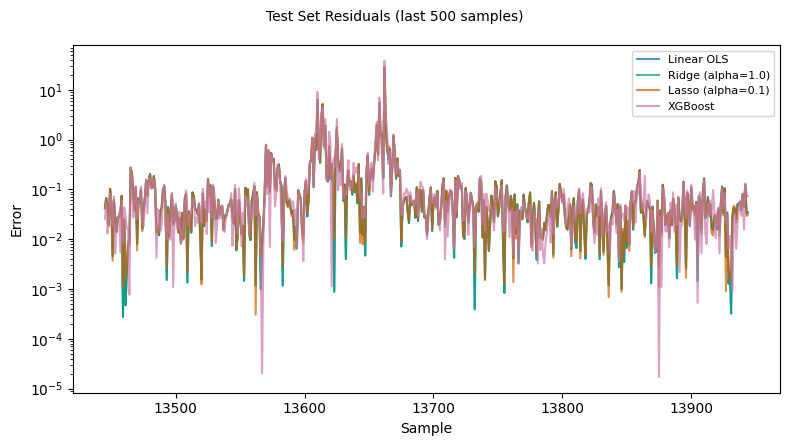

In [72]:
# Visualise prediction errors

rel_err = lambda pred, truth : np.sqrt((pred - truth)**2 / truth**2)

models = [
    (rel_err(y_test_pred, y_test), 'Linear OLS'),
    (rel_err(y_test_pred_ridge, y_test), 'Ridge (alpha=1.0)'),
    (rel_err(y_test_pred_lasso, y_test), 'Lasso (alpha=0.1)'),
    (rel_err(y_test_pred_xgb, y_test), 'XGBoost')
]

fig, ax = plt.subplots(figsize=(16/2, 9/2), layout='tight')
for (residuals, label) in models:
    ax.plot(residuals[-500:], label=label, alpha=0.7)
ax.set_xlabel('Sample', fontsize=10)
ax.set_ylabel('Error', fontsize=10)
ax.legend(fontsize=8)
ax.set_yscale('log')
plt.suptitle('Test Set Residuals (last 500 samples)', fontsize=10)
plt.show()